# Question-Answering Demo using Scottish Widows Public Documents

## Introduction

To harness the power of LLMs and improve the pretrained models' performance, there are basically three routes one can try: Prompt Engineering, [Retrieval-Augmented Generation (RAG)](https://arxiv.org/abs/2005.11401) or model Finetuning.

The RAG approach integrates the power of retrieval (or searching) into LLM text generation. It combines a retriever system, which fetches relevant document snippets from domain specific data, and an LLM, which produces answers using the information from those snippets. In essence, RAG helps the model to “look up” external information to improve its responses.

Specifically, for the vector similarity search based RAG approach, all the relevant text data such as PDFs or other documentation are chunked first. Then all the chunks are embedded into vectors and store in a vector database. When a user asks a question, the question is also embedded and a search is conducted to find the similar chunks in the embedded sapce in the hope that the most relevant answers are clustered around the question in the embedding vector space. After this retrival stage, the relevant text are extracted and use to form the context to prompt the LLM to generate an answer.

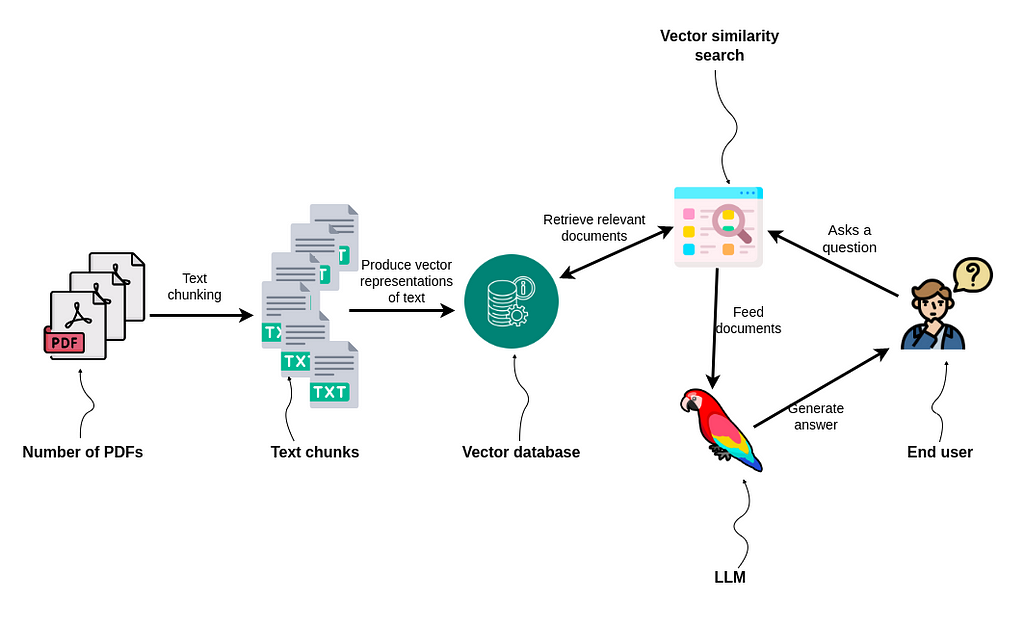

[image source](https://neo4j.com/developer-blog/knowledge-graphs-llms-multi-hop-question-answering/)


## Environment

In [ ]:
import os

import pandas as pd
import numpy as np

import faiss


pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [ ]:
import vertexai
from vertexai.preview.language_models import TextGenerationModel, TextEmbeddingModel


In [ ]:
PROJECT_ID = ! gcloud config get core/project
PROJECT_ID = PROJECT_ID[0]

REGION = "europe-west1"

PROJECT_ID, REGION

In [ ]:
%env PROJECT_ID=$PROJECT_ID

## Data

### Raw data

Document Source: Based on Scottish Widows' literature library search:
https://adviser.scottishwidows.co.uk/literature-library.html

Specifically for this demo, the *guides* are selected:
https://adviser.scottishwidows.co.uk/literature-library.html?n=1000&filter=swe:literaturelibrary/contenttype/guides

The pdf files are scrapped and save in local parquet file

In [ ]:
all_guides_file = "../data/scottish_widows_all_guides.pq"

guides_df = pd.read_parquet(all_guides_file)

guides_df.head()

In [ ]:
guides_df.groupby(["title"])[["page_number"]].count()

### Pre-processing
#### Remove the blank pages

In [ ]:
print(guides_df.shape)

guides_df = guides_df.loc[guides_df["page_text"]!=""]

print(guides_df.shape)

## Embedding using Google's `TextEmbedding` Model

**Approach 1: Using the natural pages as chunks**

In [ ]:
guides_df["page_text"].loc[0]

In [ ]:
model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

# return a list of vertexai.language_models._language_models.TextEmbedding
#embeddings = model.get_embeddings( [guides_df["page_text"].loc[0]] )
embeddings = model.get_embeddings(guides_df["page_text"].loc[0:4]) # maximum 5 instance per embedding!

len(embeddings), type(embeddings[0])

In [ ]:
for embedding in embeddings:
    vector = np.array(embedding.values)
    print(vector.shape)
    print(vector[:10])

In [ ]:
pd.Series([embedding.values for embedding in embeddings], name="embedding").to_frame()

In [ ]:
def get_embedding_google(se, chunk_size=5):
    """Using Google's pretrained TextEmbeddingModel to vetorise the text series 
       Input:
           se: Series of string
           chunk_size: number of text items send to Google API.
                       By default, GCP can process maximum 5 itmes in one go, 
                       so the chunk_size should be less than 5
        Return: Numpy array with shape (m, n), where m is the number of text 
                and n the vector length (768 for Google model)
    """
    
    model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")
    
    # generator use to iterate the series over smaller series with chunk_size rows) 
    small_se_gen = (se.iloc[i:i+chunk_size] for i in range(0, len(se), chunk_size))
    small_se_embeddings = [model.get_embeddings(small_se) for small_se in small_se_gen]

    eb_list = [
        np.array(embedding.values, dtype="float32") 
        for embeddings in small_se_embeddings 
        for embedding in embeddings
        ]
    return np.vstack(eb_list)

**To test the embdding function**

In [ ]:
# one text item each time for the 11 items embedding
v1 = get_embedding_google(guides_df["page_text"].iloc[0:11], 1)
v1.shape, v1[0][0:10]

In [ ]:
# using the default chunk size of 5 
v2 = get_embedding_google(guides_df["page_text"].iloc[0:11])
v2.shape,  v2[0][0:10]

**Note: when more than one piece of text items are send for embedding, the model returns slightly different embeddings vector. But they are very similar when using the dot product to compare!**

In [ ]:
[np.dot(v_1, v_2) for v_1, v_2 in zip(np.rollaxis(v1, 0), np.rollaxis(v2,0))]

### Embedding the whole set

In [ ]:
#%%timeit -n 1 -r 1 # how long does is take? about 1 min for 1000 rows
#get_embedding_google(guides_df["page_text"].iloc[0:100])

guides_embedded_df = pd.DataFrame(
    get_embedding_google(guides_df["page_text"]), index=guides_df.index
)

guides_embedded_df.tail()

In [ ]:
guides_df.shape, guides_embedded_df.shape

In [ ]:
guides_embedded_file = "../data/scottish_widows_all_guides_embedded_v3.pq"

In [ ]:
# guides_embedded_df.to_parquet(guides_embedded_file)

## Vector DB using Faiss

In [ ]:
#guides_embedded_df = pd.read_parquet(guides_embedded_file)

guides_embedded_df.tail()

### Create unique ID to link embedded vectors with original page

In [ ]:
guides_df = guides_df.reset_index().rename(columns={"index": "id"})

guides_df.tail()

### Build the vector DB

In [ ]:
# instantiate the index
vector_length = guides_embedded_df.shape[1]

index = faiss.IndexFlatL2(vector_length)

# Pass the index to IndexIDMap and add vectors with IDs
indexed = faiss.IndexIDMap(index)
indexed.add_with_ids(guides_embedded_df, guides_df.id.values)

print(f"Number of vectors in the Faiss index: {indexed.ntotal}")

## Query

In [ ]:
# randomly pick up a page and search. The results should include itself as the closest match
pick_page = 15 

em = guides_embedded_df.iloc[pick_page:pick_page+1, :]
distances, ids = indexed.search(em, k=3)
print(f'L2 distance: {distances[0]}\nIDs: {ids[0]}')

In [ ]:
guides_df[ guides_df.id.isin(ids[0])]

In [ ]:
def vector_search_google(query:str, index, num_results:int=3):
    """
    Encoding the query using Google's text embedding model and search the closetest matches from vector DB
    quert: the text to be embedded
    index: faiss.swigfaiss_avx2.IndexFlatL2 as vector DB
    num_results: number of matches to ruturn
    
    Returns:
        distances: distances between results and query as float or numpy array.
        ids: IDs of the maches as array.
    
    """

    model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")
    
    query_vector = np.array(model.get_embeddings([query])[0].values, dtype="float32").reshape(1, -1)

    distances, ids = index.search(query_vector, k=num_results)
    
    return distances, ids


In [ ]:
user_query = """How does the Discounted Gift & Income Trust work?"""

ds, ids = vector_search_google(user_query, indexed, num_results=3)

print(f'Euclidean distance: {ds[0]}\nPage IDs: {ids[0]}')

In [ ]:
# Fetch the paper titles based on their index
guides_df[ guides_df["id"].isin(ids[0])]

## Answer the query based on the relevant pages

In [ ]:
context = guides_df["page_text"][ guides_df["id"].isin(ids[0])].iloc[0]
question = """How does the Discounted Gift & Income Trust work?"""

template = f"""You are an expert having a conversation with a user.
Given the following extracted parts of a long document and a question,
create a final answer. 
{context}

user: {question}
expert:
"""

parameters = {
    "temperature": 0.2,
    "max_output_tokens": 256,   
    "top_p": .8,                
    "top_k": 40,                 
}

model = TextGenerationModel.from_pretrained("text-bison@001")
response = model.predict(template, **parameters)

print(f"Question: {question}\n")
print(f"Response from Model: \n{response.text}")


In [ ]:
def gen_text_google(input_text, temperature: float=0.2) -> None:
    parameters = {
        "temperature": temperature,
        "max_output_tokens": 256,   
        "top_p": .8,                
        "top_k": 40,                 
    }

    model = TextGenerationModel.from_pretrained("text-bison@001")
    response = model.predict(
        input_text,
        **parameters,
    )
    print(f"Response from Model: \n{response.text}")


In [ ]:
question = """How does the Discounted Gift & Income Trust work?"""

ds, ids = vector_search_google(question, indexed, num_results=3)

context = guides_df["page_text"][ guides_df["id"].isin(ids[0])].iloc[0]

#style = "a concise way"
style = "details"

text = f"""You are an expert having a conversation with a user.
Given the following extracted parts of a long document and a question,
create a final answer in {style}. 
{context}

user: {question}
expert:
"""

print(f"Question: {question}\n")

gen_text_google(text)

### More questions

In [ ]:
question = """Can a customer buy any products after 75?"""

ds, ids = vector_search_google(question, indexed, num_results=3)

context = guides_df["page_text"][ guides_df["id"].isin(ids[0])].iloc[0]

#style = "a concise way"
style = "details"

text = f"""You are an expert having a conversation with a user.
Given the following extracted parts of a long document and a question,
create a final answer in {style}. 
{context}

user: {question}
expert:
"""

print(f"Question: {question}\n")

gen_text_google(text)

In [ ]:
question = """Can a customer pay in after 75?"""

ds, ids = vector_search_google(question, indexed, num_results=3)

context = guides_df["page_text"][ guides_df["id"].isin(ids[0])].iloc[0]

text = f"""You are an expert having a conversation with a user.
Given the following extracted parts of a long document and a question,
{context}

user: {question}
expert:
"""

print(f"Question: {question}\n")

gen_text_google(text)

#### Irrelevant questions

In [ ]:
question = """Can a customer bring a dog?"""
#question = """Can customer's dog benefit from any products?"""
#question = """Can customer get any of the products for free?"""

ds, ids = vector_search_google(question, indexed, num_results=3)

context = guides_df["page_text"][ guides_df["id"].isin(ids[0])].iloc[0]

#style = "a concise way"
style = "details"

text = f"""You are an expert having a conversation with a user.
Given the following extracted parts of a long document and a question,
create a final answer in {style}. 
{context}

user: {question}
expert:
"""

print(f"Question: {question}\n")

gen_text_google(text)

In [ ]:
#question = """Can a customer bring a dog?"""

ds, ids = vector_search_google(question, indexed, num_results=3)

context = guides_df["page_text"][ guides_df["id"].isin(ids[0])].iloc[0]

text = f"""You are an expert having a conversation with a user.
Given the following extracted parts of a long document and a question,
If you are not sure about the question, just say "I don't have relevant information to answer this question."
{context}

user: {question}
expert:
"""

print(f"Question: {question}\n")

gen_text_google(text)

## Scratch

In [ ]:
context

In [ ]:
guides_df[ guides_df["id"].isin(ids[0])]

In [ ]:
ids[0]